#### CNN Model

In [9]:
import os
import random
import shutil
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from livelossplot.inputs.keras import PlotLossesCallback
from pathlib import Path
import numpy as np
SEED = 42

In [17]:
def split_data(folder_path, split_ratio, seed=42):
    """
    Split the data in the given folder into training and testing sets.
    `folder_path`: The path to the folder containing the data.
    `split_ratio`: The fraction of data to be used for training (between 0 and 1).
    """
    # Create the directories for the training and testing data.
    train_path = os.path.join(folder_path, 'train')
    test_path = os.path.join(folder_path, 'test')
    os.makedirs(train_path, exist_ok=True)
    os.makedirs(test_path, exist_ok=True)

    random.seed(seed)

    # Loop through each folder in the main folder.
    for class_name in os.listdir(folder_path):
        if class_name != 'train' and class_name != 'test':
            class_path = os.path.join(folder_path, class_name)
            if not os.path.isdir(class_path):
                continue

            # Get a list of all the image files in the current class folder.
            image_files = [f for f in os.listdir(class_path) if f.endswith('.jpg') or f.endswith('.png')]

            # Shuffle the list of image files.
            random.shuffle(image_files)

            # Split the image files into training and testing sets.
            split_index = int(len(image_files) * split_ratio)
            train_files = image_files[:split_index]
            test_files = image_files[split_index:]

            # Create the subdirectories for the training and testing data.
            train_class_path = os.path.join(train_path, class_name)
            test_class_path = os.path.join(test_path, class_name)
            os.makedirs(train_class_path, exist_ok=True)
            os.makedirs(test_class_path, exist_ok=True)

            # Move the training files to the appropriate directory.
            for file_name in train_files:
                src_path = os.path.join(class_path, file_name)
                dst_path = os.path.join(train_class_path, file_name)
                shutil.copy(src_path, dst_path)

            # Move the testing files to the appropriate directory.
            for file_name in test_files:
                src_path = os.path.join(class_path, file_name)
                dst_path = os.path.join(test_class_path, file_name)
                shutil.copy(src_path, dst_path)
    return test_path, train_path


#### Split the Data into seperate folders for Train and Test

In [18]:
test_path, train_path = split_data('../images/', 0.8, SEED)

### Model and Data Generator Code
I followed learndatasci.com's tutorial on how to train a pretrained CNN model for image classification along. This provided a solid base to start at. I then tweaked things to better fit my model

Tutorial link: https://www.learndatasci.com/tutorials/hands-on-transfer-learning-keras/

In [15]:
test_path = "../images/test"
train_path = "../images/train"
# specify the batch size and image size
BATCH_SIZE = 32
img_size = (224, 224)

class_subset = sorted(os.listdir(train_path))
print(class_subset)
# create an instance of the ImageDataGenerator class for data augmentation
data_generator = ImageDataGenerator(
    rotation_range=90, 
    brightness_range=[0.1, 0.7],
    width_shift_range=0.5, 
    height_shift_range=0.5,
    horizontal_flip=True, 
    vertical_flip=True,
    validation_split=0.3,
    preprocessing_function=preprocess_input
)
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

traingen = data_generator.flow_from_directory(train_path,
                                               target_size=img_size,
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='training',
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True,
                                               seed=SEED)

validgen = data_generator.flow_from_directory(train_path,
                                               target_size=img_size,
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='validation',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=SEED)

testgen = test_generator.flow_from_directory(test_path,
                                             target_size=(224, 224),
                                             class_mode=None,
                                             classes=class_subset,
                                             batch_size=1,
                                             shuffle=False,
                                             seed=42)


['K2', 'Kangchenjunga', 'Mauna Kea', 'Mt Denali', 'Mt Everest', 'Mt Fitz Roy', 'Mt Fuji', 'Mt Hood', 'Mt Kilimanjaro', 'Mt Rainier', 'Mt Whitney']
Found 9679 images belonging to 11 classes.
Found 4140 images belonging to 11 classes.
Found 3460 images belonging to 11 classes.


In [16]:
def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    """
    Compiles a model integrated with VGG16 pretrained layers
    
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """
    
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = VGG16(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)
    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(4096, activation='relu')(top_model)
    top_model = Dense(1072, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model


In [17]:
input_shape = (224, 224, 3)
optim_1 = Adam(learning_rate=0.0005)
n_classes=len(class_subset)

n_steps = traingen.samples // BATCH_SIZE
n_val_steps = validgen.samples // BATCH_SIZE
n_epochs = 50

# First we'll train the model without Fine-tuning
vgg_model = create_model(input_shape, n_classes, optim_1, fine_tune=0)


In [49]:
plot_loss_1 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='../models/tl_model_v1.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')


In [4]:
%%time 

vgg_history = vgg_model.fit(traingen,
                            batch_size=BATCH_SIZE,
                            epochs=n_epochs,
                            validation_data=validgen,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[tl_checkpoint_1, early_stop, plot_loss_1],
                            verbose=1)


NameError: name 'vgg_model' is not defined

In [18]:
traingen.reset()
validgen.reset()

# Use a smaller learning rate
optim_2 = Adam(lr=0.000075)

# Re-compile the model, this time leaving the last 2 layers unfrozen for Fine-Tuning
vgg_model_ft = create_model(input_shape, n_classes, optim_2, fine_tune=2)


/home/dominic/.pyenv/versions/3.10.6/envs/mountainid_env/lib/python3.10/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


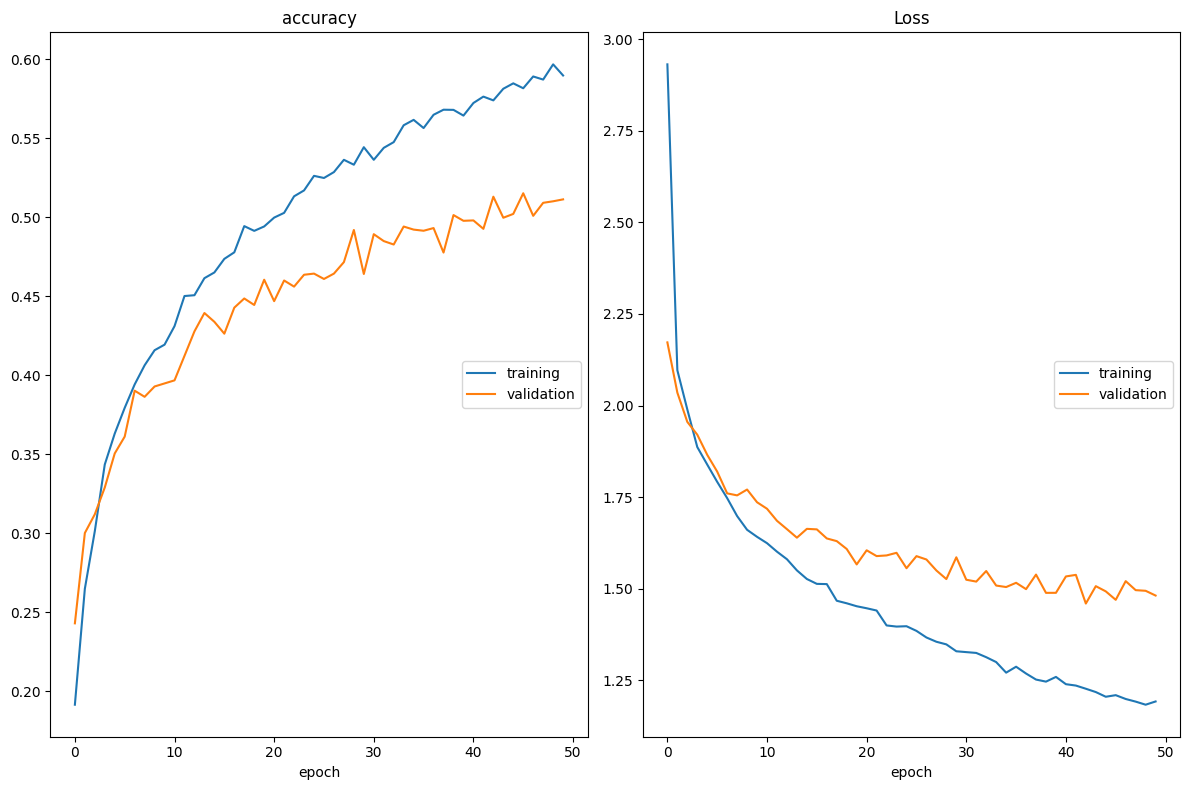

accuracy
	training         	 (min:    0.191, max:    0.597, cur:    0.590)
	validation       	 (min:    0.243, max:    0.515, cur:    0.511)
Loss
	training         	 (min:    1.184, max:    2.931, cur:    1.192)
	validation       	 (min:    1.460, max:    2.172, cur:    1.482)
302/302 [==============================] - 924s 3s/step - loss: 1.1925 - accuracy: 0.5898 - val_loss: 1.4815 - val_accuracy: 0.5114
CPU times: user 4d 3h 40min 12s, sys: 5min, total: 4d 3h 45min 13s
Wall time: 12h 28min 43s


In [24]:
%%time

# ModelCheckpoint callback - save best weights
tl_checkpoint_2 = ModelCheckpoint(filepath='../models/tl_model_v3.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop_2 = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

plot_loss_2 = PlotLossesCallback()

# Retrain model with fine-tuning
vgg_ft_history = vgg_model_ft.fit(traingen,
                                  batch_size=BATCH_SIZE,
                                  epochs=n_epochs,
                                  validation_data=validgen,
                                  steps_per_epoch=n_steps, 
                                  validation_steps=n_val_steps,
                                  callbacks=[tl_checkpoint_2, early_stop_2, plot_loss_2],
                                  verbose=1)
file_count = 0
file_list = os.listdir("../models")
for file in file_list:
    file_count += 1
model_save_path = '../models/tl_model_v' + str(file_count) + '.h5'
vgg_model_ft.save(model_save_path)

In [19]:
from sklearn.metrics import accuracy_score
vgg_model.load_weights('../models/tl_model_v5.h5') # initialize the best trained weights

image_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

image_gen = image_gen.flow_from_directory(test_path,
                                             target_size=(224, 224),
                                             class_mode=None,
                                             classes=class_subset,
                                             batch_size=1,
                                             shuffle=False,
                                             seed=42)

true_classes = testgen.classes
class_indices = traingen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

vgg_preds = vgg_model.predict(testgen)
vgg_pred_classes = np.argmax(vgg_preds, axis=1)

vgg_acc = accuracy_score(true_classes, vgg_pred_classes)
print("VGG16 Model Accuracy {:.2f}%".format(vgg_acc * 100))



Found 3460 images belonging to 11 classes.


2023-05-03 19:52:10.519661: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


3460/3460 [==============================] - 363s 105ms/step
VGG16 Model Accuracy without Fine-Tuning: 61.97%


### Test the Model

In [1]:
from sklearn.metrics import accuracy_score
vgg_model.load_weights('../models/tl_model_v5.h5') # initialize the best trained weights

true_classes = testgen.classes
class_indices = traingen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

vgg_preds = vgg_model.predict(testgen)
vgg_pred_classes = np.argmax(vgg_preds, axis=1)

vgg_acc = accuracy_score(true_classes, vgg_pred_classes)
print("VGG16 Model Accuracy: {:.2f}%".format(vgg_acc * 100))



NameError: name 'vgg_model' is not defined

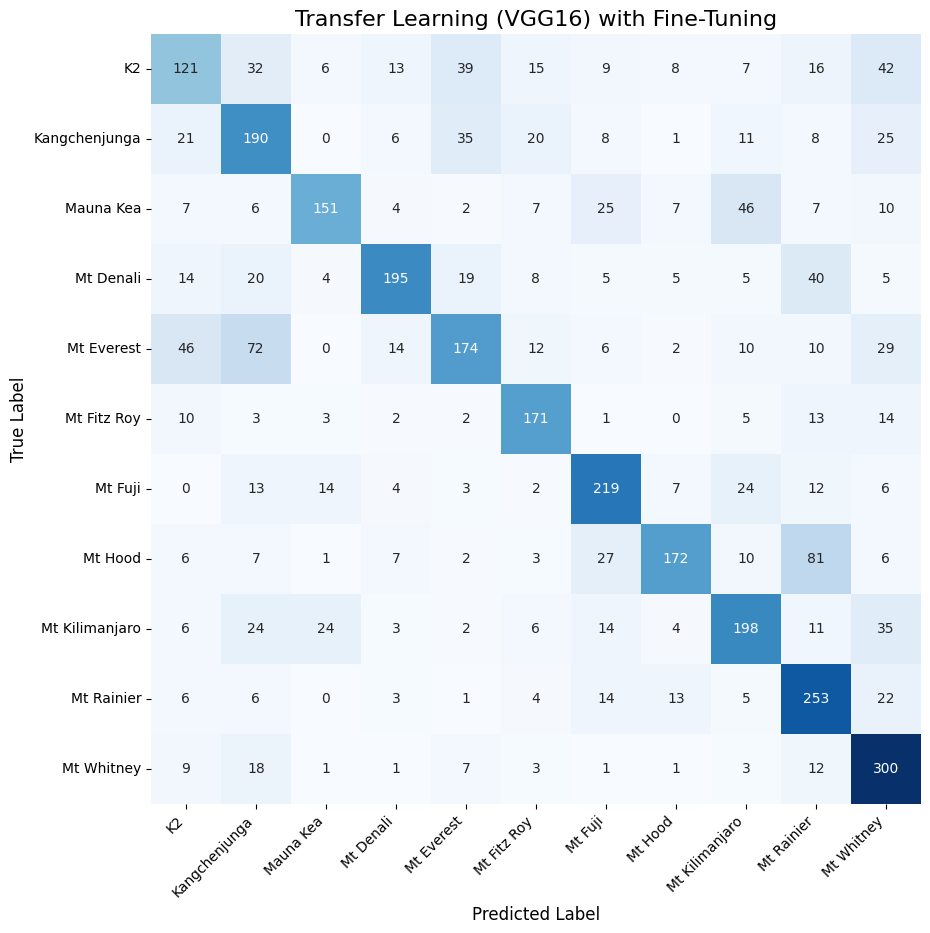

In [30]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Get the names of the ten classes
class_names = testgen.class_indices.keys()

# Plot heatmap
fig, ax = plt.subplots(figsize=(10,10))
cm = confusion_matrix(true_classes, vgg_pred_classes)
sns.heatmap(
    cm, 
    annot=True, 
    square=True, 
    xticklabels=class_names, 
    yticklabels=class_names,
    fmt='d', 
    cmap=plt.cm.Blues,
    cbar=False,
    ax=ax
)
ax.set_title("Transfer Learning (VGG16) with Fine-Tuning", fontsize=16)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_ylabel('True Label', fontsize=12)
ax.set_xlabel('Predicted Label', fontsize=12)

plt.show()
